In [58]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import MeanSquaredError
import numpy as np

# Assuming data is loaded similar to arima_1.py
data = pd.read_csv('C:/Users/Wilson/Desktop/TB2/Dataminiproject/Dataset/UoB_Set01_2025-01-02tapes.csv', header=None, names=['seconds', 'transaction_price', 'number_of_transactions'])
data['timestamp'] = pd.to_timedelta(data['seconds'], unit='s') + pd.Timestamp('2025-01-02 00:00')
data.set_index(keys='timestamp', inplace=True)
resampled_data = data['transaction_price'].resample('1S').mean()
resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(resampled_data_ffill.values.reshape(-1,1))


In [59]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # Based on previous timestep
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [60]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=32, verbose=2)



Epoch 1/30
765/765 - 8s - loss: 0.0665 - 8s/epoch - 10ms/step
Epoch 2/30
765/765 - 3s - loss: 0.0055 - 3s/epoch - 4ms/step
Epoch 3/30
765/765 - 3s - loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 4/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 5/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 6/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 7/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 8/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 9/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 10/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 11/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 12/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 13/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 14/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 15/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 16/30
765/765 - 3s - loss: 0.0015 - 3s/epoch - 4ms/step
Epoch 17/30
765/

In [61]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


192/192 [==============================] - 1s 3ms/step


Train Score: 2.29 RMSE
Test Score: 2.28 RMSE


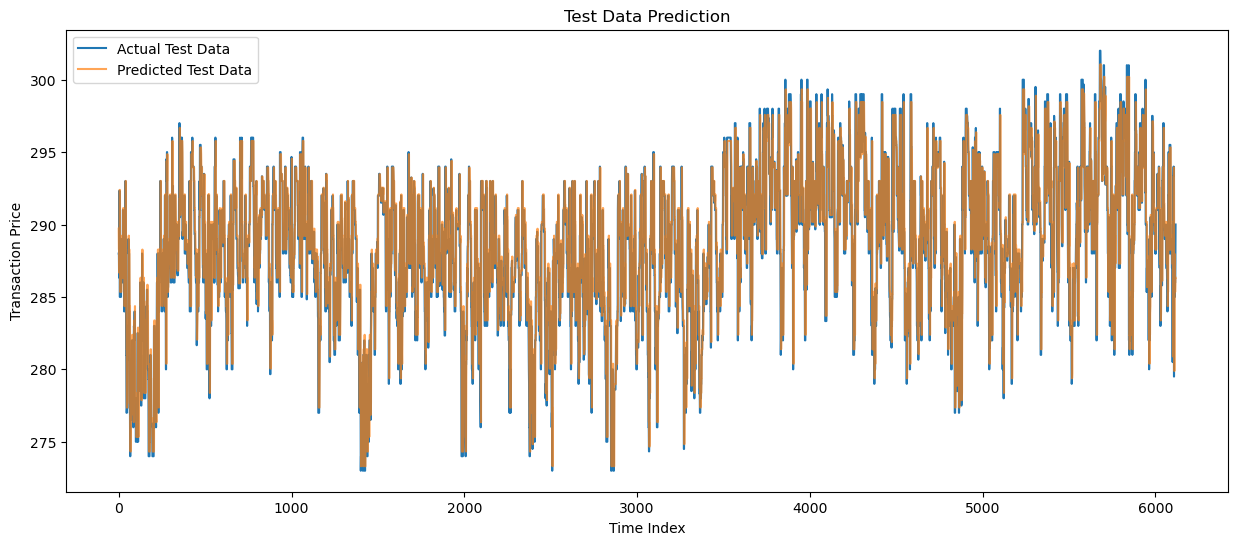

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for training and test sets
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')

# Calculate indices for test data in the original dataset
test_data_start_index = len(scaled_data) - test_size

# Prepare test data from original dataset for plotting
original_test_data = scaler.inverse_transform(scaled_data[test_data_start_index:])

# Prepare test predictions for plotting
# Note: The testPredict has already been scaled back to the original scale

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(original_test_data, label='Actual Test Data')
plt.plot(testPredict, label='Predicted Test Data', alpha=0.7)
plt.title('Test Data Prediction')
plt.xlabel('Time Index')
plt.ylabel('Transaction Price')
plt.legend()
plt.show()
